## Generating a Table of Global Fluxes

This notebook reads in the CESM1 historical run (for CMIP5),
the ensemble of 11 CESM2 historical runs (for CMIP6),
and also the four SSP CESM2 ensembles (for CMIP6).
A table is generated containing values listed [issue #6](https://github.com/marbl-ecosys/cesm2-marbl/issues/6)


> * Net primary production (PgC/yr) (`photoC_TOT_zint`)
> * Diatom primary production (%)   (`photoC_diat_zint`)
> * Sinking POC at 100 m (PgC/yr)   (`POC_FLUX_100m`)
> * Sinking CaCO3 at 100 m (PgC/yr) (`CaCO3_FLUX_100m`)
> * Rain ratio (CaCO3/POC) 100 m    (ratio of two above)
> * Nitrogen fixation (TgN/yr)      (`diaz_Nfix`)
> * Nitrogen deposition (TgN/yr)    (`NOx_FLUX` + `NHy_FLUX`)
> * Denitrification (TgN/yr)        (`DENITRIF`)
> * N cycle imbalance = deposition + fixation - denitrification (TgN/yr) # deposition = N* [see Kristen's notebook -- Biological Diagnostics?]
> * Air–sea CO2 flux (PgC yr21)     (`FG_CO2`)
> * Mean ocean oxygen (uM = umol/L = mmol/m^3)    (`O2`)
> * Volume where O2 <80 mmol/m^3 (10^15 m^3) # based on others
> * Volume where O2 <60 mmol/m^3 (10^15 m^3) # based on others
> * Volume where O2 <5 mmol/m^3 (10^15 m^3)  # based on others

Values will be computed one at a time, due to an issue with `xr.merge` and trying to read multiple variables at once.

### This notebook uses several python packages

The watermark package shows the version number used to help others recreate this environment.

In [1]:
import os

import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from pint import UnitRegistry

# Add new units to UnitRegistry
units = UnitRegistry()
units.define('gram N = mol / 14 = gN')
units.define('gram C = mol / 12 = gC')
units.define('year = 365 day = yr')

%load_ext watermark
%watermark -d -iv -m -g -h

xarray     0.14.0
matplotlib 3.1.2
pandas     0.25.3
numpy      1.17.3
2020-01-29 

compiler   : GCC 7.3.0
system     : Linux
release    : 3.10.0-693.21.1.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
host name  : casper10
Git hash   : b458b3c9308d8ca665c306e8a4812d5d940c6263


### Define our experiments

In [2]:
# Should the annual averages include the marginal seas or just be open ocean?
# (USE TRUE FOR PAPER)
include_marg_seas = True
# include_marg_seas = False
xp_dir = 'with_marginal_seas' if include_marg_seas else 'no_marginal_seas'

# Process for updating intake-esm catalog
#       1. download all data from HPSS via get_ocn_cmip5_files.sh
#       2. rm /glade/u/home/mlevy/.intake_esm/collections/CESM1-CMIP5.nc
#       3. regenerate it via Anderson's legacy intake-esm
#       4. re-run build intake collections notebook
#       5. commit change to .csv.gz in /glade/work/mlevy/intake-esm-collection/csv.gz/
# NOTE: steps 2-5 can be done with notebooks/intake-esm-collection-defs/rebuild.sh
vars = [
        'photoC_TOT_zint_100m', 'photoC_diat_zint_100m',
        'photoC_TOT_zint', 'photoC_diat_zint',
        'POC_FLUX_100m', 'CaCO3_FLUX_100m',
        'diaz_Nfix', 'NOx_FLUX', 'NHy_FLUX', 'DENITRIF',
        'SedDenitrif', 'DON_RIV_FLUX', 'DONr_RIV_FLUX',
        'FG_CO2', 'O2' ,
        'O2_under_thres' # add a thres dimension corresponding to limits
       ]
# experiments is a list of experiments to compute values for
experiments = dict()
experiments['cesm1'] = ['cesm1_PI',
                        'cesm1_PI_esm',
                        'cesm1_hist',
                        'cesm1_hist_esm',
                        'cesm1_RCP85',
                       ]
               # CESM 2
experiments['cesm2'] = ['cesm2_PI',
                        'cesm2_hist',
                        'cesm2_SSP1-2.6',
                        'cesm2_SSP2-4.5',
                        'cesm2_SSP3-7.0',
                        'cesm2_SSP5-8.5',
                       ]

# experiment_longnames defines the table headers
experiment_longnames={'cesm1_PI' : 'preindustrial (CESM1)',
                      'cesm1_PI_esm' : 'preindustrial (CESM1, BPRP)',
                      'cesm1_hist' : '1981-2005 (CESM1)',
                      'cesm1_hist_esm' : '1990s (CESM1)',
                      'cesm1_RCP45' : 'RCP 4.5 2090s (CESM1)', # not available yet
                      'cesm1_RCP85' : 'RCP 8.5 2090s (CESM1)',
                      'cesm1_RCP85_esm' : 'RCP 8.5 2090s (CESM1)',
                      'cesm2_PI' : 'preindustrial (CESM2)',
                      'cesm2_hist' : '1990-2014 (CESM2)',
                      'cesm2_SSP1-2.6' : 'RCP26 2090s (CESM2)',
                      'cesm2_SSP2-4.5' : 'RCP45 2090s (CESM2)',
                      'cesm2_SSP3-7.0' : 'RCP70 2090s (CESM2)',
                      'cesm2_SSP5-8.5' : 'RCP85 2090s (CESM2)'}

# experiment_dict determines which module version & intake data each experiment uses
experiment_dict = {'cesm1_PI' : ('cesm1', 'piControl'),
                   'cesm1_PI_esm' : ('cesm1', 'esm-piControl'),
                   'cesm1_hist' : ('cesm1', 'historical'),
                   'cesm1_hist_esm' : ('cesm1', 'esm-hist'),
                   'cesm1_RCP85' : ('cesm1', 'RCP-8.5'),
                   'cesm1_RCP85_esm' : ('cesm1', 'esm-RCP-8.5'),
                   'cesm2_PI' : ('cesm2', 'piControl'),
                   'cesm2_hist' : ('cesm2', 'historical'),
                   'cesm2_SSP1-2.6' : ('cesm2', 'SSP1-2.6'),
                   'cesm2_SSP2-4.5' : ('cesm2', 'SSP2-4.5'),
                   'cesm2_SSP3-7.0' : ('cesm2', 'SSP3-7.0'),
                   'cesm2_SSP5-8.5' : ('cesm2', 'SSP5-8.5')
                  }

#### Read output from Make Timeseries.ipynb

Files were written by `xpersist` and are read in using `xr.open_dataset`

In [3]:
%%time

cache_dir = os.path.join(os.path.sep, 'glade', 'p', 'cgd', 'oce', 'projects', 'cesm2-marbl', 'xpersist_cache', xp_dir)

ann_avg = dict()
new_units = dict()
for variable in vars:
    ann_avg[variable] = dict()
    new_units[variable] = dict()
    for model_version in experiments:
        # Skip files that are not written out for CESM1
        if model_version == 'cesm1' and variable in ['SedDenitrif', 'DON_RIV_FLUX', 'DONr_RIV_FLUX']:
            continue
        for exp in experiments[model_version]:
            filename = f'{exp}_{variable}.nc'
            ann_avg[variable][exp] = xr.open_dataset(os.path.join(cache_dir, filename))
            new_units[variable][exp] = units[ann_avg[variable][exp][variable].attrs['units']]

CPU times: user 1.34 s, sys: 119 ms, total: 1.46 s
Wall time: 1.71 s


In [4]:
# Build time series that combines cesm1_hist to 2004 and cesm1_RCP85 after
if 'cesm1_hist' in experiments['cesm1'] and 'cesm1_RCP85' in experiments['cesm1']:
    experiment_longnames['cesm1_hist_RCP85'] = '1990 - 2014 (CESM1)'
    for var in ann_avg:
        if 'cesm1_hist' in ann_avg[var]:
            ann_avg[var]['cesm1_hist_RCP85'] = xr.concat([ann_avg[var]['cesm1_hist'].isel(time=slice(0,-1)),
                                                          ann_avg[var]['cesm1_RCP85']],
                                                         dim='time'
                                                        )
            new_units[var]['cesm1_hist_RCP85'] = new_units[var]['cesm1_hist'].copy()

## Reduce Data Sets

Data has been reduced to annual means, but the netcdf files contain every year in the dataset.
For generating tables, we want to look at specific time periods.

####  Define the time periods we will average over

This could be done earlier in the notebook, but I think it makes sense to wait until we have annual / global means.

In [5]:
# NOTE: 2090-01-01 0:00:00 is the time stamp on the Dec 2089 monthly average
#       So slice("2090", "2100") would actually return Dec 2090 - Nov 2099
#       Specifying a day mid-month gets us to Jan 2090 - Dec 2099 (the 2090s)
#       (this can be verified by looking at time bounds)
time_slices_SSP = slice("2090-01-15", "2100-01-15")

time_slices = dict()

# 200 year averages for CESM1 PI runs, per Lindsay et al 2014
# (He starts 30 years prior to branch point, so I will too)
time_slices['cesm1_PI'] = slice(120, 320) # cfunits doesn't years too far in past; this is 121-07-01 - 320-07-01
time_slices['cesm1_PI_esm'] = slice(320, 520) # cfunits doesn't years too far in past; this is 321-07-01 - 520-07-01
# For CESM2, going from 50 years prior to first historical branch point
#                  to 50 years after end of last historical member
# TODO: These dates should be computed automatically based on intake metadata!
time_slices['cesm2_PI'] = slice(550, 1070) # cfunits doesn't years too far in past; this is 551-07-01 - 1070-07-01

# Historical runs all use slightly different time periods
# Note: that the annual mean data is actually running from July 1st to June 30th
#       these slices were defined to work with monthly data, but pick up the correct years as well
time_slices['cesm1_hist'] = slice("1981-01-15", "2006-01-15") # per Lindsay et al 2014
time_slices['cesm1_hist_esm'] = slice("1990-01-15", "2000-01-15") # per Moore et al 2013
time_slices['cesm1_hist_RCP85'] = slice("1990-01-15", "2015-01-15") # For our paper
time_slices['cesm2_hist'] = slice("1990-01-15", "2015-01-15") # For our paper

# RCP runs use 2090s
time_slices['cesm1_RCP45'] = time_slices_SSP
time_slices['cesm1_RCP85'] = time_slices_SSP
time_slices['cesm1_RCP85_esm'] = time_slices_SSP
time_slices['cesm2_SSP1-2.6'] = time_slices_SSP
time_slices['cesm2_SSP2-4.5'] = time_slices_SSP
time_slices['cesm2_SSP3-7.0'] = time_slices_SSP
time_slices['cesm2_SSP5-8.5'] = time_slices_SSP

In [6]:
# Verify time bounds for each experiment
for exp in ann_avg[vars[0]]:
    try:
        bounds = list(ann_avg[vars[0]][exp].sel(time=time_slices[exp]).time_bound.values[ind] for ind in [(0,0), (-1,-1)])
    except:
        bounds = list(ann_avg[vars[0]][exp].isel(time=time_slices[exp]).time_bound.values[ind] for ind in [(0,0), (-1,-1)])
    print(f'Experiment: {exp}\nRequested time bounds\n----\n{bounds}\n\n')

Experiment: cesm1_PI
Requested time bounds
----
[cftime.DatetimeNoLeap(121, 1, 1, 0, 0, 0, 0, 2, 1), cftime.DatetimeNoLeap(321, 1, 1, 0, 0, 0, 0, 6, 1)]


Experiment: cesm1_PI_esm
Requested time bounds
----
[cftime.DatetimeNoLeap(321, 1, 1, 0, 0, 0, 0, 6, 1), cftime.DatetimeNoLeap(521, 1, 1, 0, 0, 0, 0, 3, 1)]


Experiment: cesm1_hist
Requested time bounds
----
[cftime.DatetimeNoLeap(1981, 1, 1, 0, 0, 0, 0, 0, 1), cftime.DatetimeNoLeap(2006, 1, 1, 0, 0, 0, 0, 4, 1)]


Experiment: cesm1_hist_esm
Requested time bounds
----
[cftime.DatetimeNoLeap(1990, 1, 1, 0, 0, 0, 0, 2, 1), cftime.DatetimeNoLeap(2000, 1, 1, 0, 0, 0, 0, 5, 1)]


Experiment: cesm1_RCP85
Requested time bounds
----
[cftime.DatetimeNoLeap(2090, 1, 1, 0, 0, 0, 0, 4, 1), cftime.DatetimeNoLeap(2100, 1, 1, 0, 0, 0, 0, 0, 1)]


Experiment: cesm2_PI
Requested time bounds
----
[cftime.DatetimeNoLeap(551, 1, 1, 0, 0, 0, 0, 5, 1), cftime.DatetimeNoLeap(1071, 1, 1, 0, 0, 0, 0, 0, 1)]


Experiment: cesm2_hist
Requested time bounds
---

#### Define the units to use in final table

Note that in the first cell of the notebook, we defined a year to be 365 days as well as `PgC` and `TgN` units.

In [7]:
# Define final units
PgC_per_year = 'PgC/yr'
TgN_per_year = 'TgN/yr'
uM = 'uM'

final_units = dict()
final_units['photoC_TOT_zint'] = PgC_per_year
final_units['photoC_diat_zint'] = PgC_per_year
final_units['photoC_TOT_zint_100m'] = PgC_per_year
final_units['photoC_diat_zint_100m'] = PgC_per_year
final_units['POC_FLUX_100m'] = PgC_per_year
final_units['CaCO3_FLUX_100m'] = PgC_per_year
final_units['diaz_Nfix'] = TgN_per_year
final_units['NOx_FLUX'] = TgN_per_year
final_units['NHy_FLUX'] = TgN_per_year
final_units['DENITRIF'] = TgN_per_year
final_units['SedDenitrif'] = TgN_per_year
final_units['DON_RIV_FLUX'] = TgN_per_year
final_units['DONr_RIV_FLUX'] = TgN_per_year
final_units['FG_CO2'] = PgC_per_year
final_units['O2'] = 'uM'
final_units['O2_under_thres'] = 'Pm * m^2'

#### Define labels for rows in each table

Also determine correct number of digits to write each value out to

In [8]:
# Define keys that will go into table columns

def O2_vol_keys(o2_thres):
    if o2_thres == 20:
        return f'OMZ volume (10$^1$$^5$ m$^3$; <20 $\mu$M)'
    return f'Volume (10$^1$$^5$ m$^3$) where O$_2$ <{o2_thres} $\mu$M)'

# SETTING UP NAMES FOR ALL TABLE KEYS
POC_key = f'Sinking POC at 100 m ({PgC_per_year})'
CaCO3_key = f'Sinking CaCO$_3$ at 100 m ({PgC_per_year})'
rain_key = f'Rain ratio (CaCO$_3$/POC) at 100 m'
NPP_key = f'Net primary production, full depth ({PgC_per_year})'
NPP_diat_key = f'Diatom primary production, full depth (%)'
NPP_100m_key = f'Net primary production, top 100m ({PgC_per_year})'
NPP_diat_100m_key = f'Diatom primary production, top 100m (%)'
Nfix_key = f'Nitrogen fixation ({TgN_per_year})'
Ndep_key = f'Nitrogen deposition ({TgN_per_year})'
denitrif_key = f'Water Column Denitrification ({TgN_per_year})'
denitrif2_key = f'Sediment Denitrification ({TgN_per_year})'
rivflux_key = f'Nitrogen River Flux ({TgN_per_year})'
Ncycle_key = f'N cycle imbalance* ({TgN_per_year})'
CO2_key = f'Air–sea CO2 flux ({PgC_per_year})'
O2_key = f'Mean ocean oxygen ($\mu$M)'

# Define rounding digit count here
rounding = dict()
rounding[POC_key] = 2
rounding[CaCO3_key] = 3
rounding[rain_key] = 3
rounding[NPP_key] = 1
rounding[NPP_diat_key] = 0
rounding[NPP_100m_key] = 1
rounding[NPP_diat_100m_key] = 0
rounding[Nfix_key] = 0
rounding[Ndep_key] = 1
rounding[denitrif_key] = 0
rounding[denitrif2_key] = 0
rounding[rivflux_key] = 0
rounding[Ncycle_key] = 0
rounding[CO2_key] = 2
rounding[O2_key] = 0
for o2_thres in [5, 20, 60, 80]:
    rounding[O2_vol_keys(o2_thres)] = 0

#### Average over all ensemble members and time (for proper time period)

In [9]:
def get_time_and_ensemble_mean(variable, ann_avg, exp, new_units, final_units):
    try:
        if exp in ['cesm1_PI', 'cesm1_PI_esm', 'cesm2_PI']:
            # Need isel instead of sel since PI slices are in index space rather than years
            ens_time_mean = (ann_avg[variable][exp][variable].isel(time=time_slices[exp]).mean('member_id')).mean('time').values
        else:
            ens_time_mean = (ann_avg[variable][exp][variable].sel(time=time_slices[exp]).mean('member_id')).mean('time').values
    except:
        print(f'   * Can not compute {variable} for {exp}')
        return('-')
    return((ens_time_mean * new_units[variable][exp]).to(final_units[variable]))

In [10]:
%%time

diagnostic_values = dict()
for model_version in experiments:
    exp_loop = experiments[model_version]
    if model_version == 'cesm1' and 'cesm1_hist' in exp_loop and 'cesm1_RCP85' in exp_loop:
        exp_loop.append('cesm1_hist_RCP85')
    for exp in exp_loop:
        diagnostic_values[exp] = dict()
        # Compute each value by hand
        print(f'Computing 100m POC flux for {exp}')
        diagnostic_values[exp][POC_key] = get_time_and_ensemble_mean('POC_FLUX_100m', ann_avg, exp, new_units, final_units)

        print(f'Computing 100m CaCO3 flux for {exp}')
        diagnostic_values[exp][CaCO3_key] = get_time_and_ensemble_mean('CaCO3_FLUX_100m', ann_avg, exp, new_units, final_units)

        print(f'Computing 100m rain rate for {exp}')
        try:
            diagnostic_values[exp][rain_key] = (diagnostic_values[exp][CaCO3_key] /
                                                 diagnostic_values[exp][POC_key])
        except:
            print(f'   * Can not compute rain rate for {exp}')

        print(f'Computing full depth net primary production for {exp}')
        diagnostic_values[exp][NPP_key] = get_time_and_ensemble_mean('photoC_TOT_zint', ann_avg, exp, new_units, final_units)

        print(f'Computing full depth primary production from diatoms for {exp}')
        try:
            diagnostic_values[exp][NPP_diat_key] = 100*(get_time_and_ensemble_mean('photoC_diat_zint', ann_avg, exp, new_units, final_units) /
                                                        diagnostic_values[exp][NPP_key])
        except:
            print(f'   * Can not compute primary production from diatoms for {exp}')

        print(f'Computing top 100m net primary production for {exp}')
        diagnostic_values[exp][NPP_100m_key] = get_time_and_ensemble_mean('photoC_TOT_zint_100m', ann_avg, exp, new_units, final_units)

        print(f'Computing top 100m primary production from diatoms for {exp}')
        try:
            diagnostic_values[exp][NPP_diat_100m_key] = 100*(get_time_and_ensemble_mean('photoC_diat_zint_100m', ann_avg, exp, new_units, final_units) /
                                                        diagnostic_values[exp][NPP_100m_key])
        except:
            print(f'   * Can not compute primary production from diatoms for {exp}')

        print(f'Computing Nfixation for {exp}')
        diagnostic_values[exp][Nfix_key] = get_time_and_ensemble_mean('diaz_Nfix', ann_avg, exp, new_units, final_units)

        print(f'Computing Ndep for {exp}')
        diagnostic_values[exp][Ndep_key] = (get_time_and_ensemble_mean('NOx_FLUX', ann_avg, exp, new_units, final_units) +
                                            get_time_and_ensemble_mean('NHy_FLUX', ann_avg, exp, new_units, final_units))

        print(f'Computing Water Column Denitrif for {exp}')
        diagnostic_values[exp][denitrif_key] = get_time_and_ensemble_mean('DENITRIF', ann_avg, exp, new_units, final_units)

        print(f'Computing Sediment Denitrif for {exp}')
        diagnostic_values[exp][denitrif2_key] = get_time_and_ensemble_mean('SedDenitrif', ann_avg, exp, new_units, final_units)

        print(f'Computing Nitrogen River Flux for {exp}')
        diagnostic_values[exp][rivflux_key] = (get_time_and_ensemble_mean('DON_RIV_FLUX', ann_avg, exp, new_units, final_units) +
                                               get_time_and_ensemble_mean('DONr_RIV_FLUX', ann_avg, exp, new_units, final_units))

        print(f'Computing Nitrogen Cycle imbalance for {exp}')
        table_key = 'N cycle imbalance* (TgN yr$^{-1}$)'
        try:
            diagnostic_values[exp][Ncycle_key] = (diagnostic_values[exp][Ndep_key] +
                                                  diagnostic_values[exp][Nfix_key] -
                                                  diagnostic_values[exp][denitrif_key])
            try:
                diagnostic_values[exp][Ncycle_key] = (diagnostic_values[exp][Ncycle_key] -
                                                      diagnostic_values[exp][denitrif2_key] - 
                                                      diagnostic_values[exp][rivflux_key])
            except:
                print(f'   * No additional denitrification terms for {exp}')
                pass
        except:
            print(f'   * Can not compute Ncycle imbalance for {exp}')

        print(f'Computing air-sea CO2 Flux for {exp}')
        diagnostic_values[exp][CO2_key] = get_time_and_ensemble_mean('FG_CO2', ann_avg, exp, new_units, final_units)

        # Update O2 units to account for fact that we are dividing my total volume
        print(f'Computing O2 concentration for {exp}')
        try:
            diagnostic_values[exp][O2_key] = get_time_and_ensemble_mean('O2', ann_avg, exp, new_units, final_units)
        except:
            print(f'   * Can not compute O2 concentration for {exp}')

        try:
            if exp in ann_avg['O2_under_thres']:
                for n, o2_thres in enumerate(ann_avg['O2_under_thres'][exp]['o2_thres'].data):
                    print(f'Computing volume where O2 < {o2_thres} uM for {exp}')
                    diagnostic_values[exp][O2_vol_keys(o2_thres)] = get_time_and_ensemble_mean('O2_under_thres', ann_avg, exp, new_units, final_units)[n]
        except:
            print(f'   * Can not compute O2 volumes under thresholds for {exp}')

        if exp != experiments[model_version][-1]:
            print('\n----\n')


Computing 100m POC flux for cesm1_PI
Computing 100m CaCO3 flux for cesm1_PI
Computing 100m rain rate for cesm1_PI
Computing full depth net primary production for cesm1_PI
Computing full depth primary production from diatoms for cesm1_PI
Computing top 100m net primary production for cesm1_PI
Computing top 100m primary production from diatoms for cesm1_PI
Computing Nfixation for cesm1_PI
Computing Ndep for cesm1_PI
Computing Water Column Denitrif for cesm1_PI
Computing Sediment Denitrif for cesm1_PI
   * Can not compute SedDenitrif for cesm1_PI
Computing Nitrogen River Flux for cesm1_PI
   * Can not compute DON_RIV_FLUX for cesm1_PI
   * Can not compute DONr_RIV_FLUX for cesm1_PI
Computing Nitrogen Cycle imbalance for cesm1_PI
   * No additional denitrification terms for cesm1_PI
Computing air-sea CO2 Flux for cesm1_PI
Computing O2 concentration for cesm1_PI
Computing volume where O2 < 5 uM for cesm1_PI
Computing volume where O2 < 20 uM for cesm1_PI
Computing volume where O2 < 60 uM for 

#### Make timeseries plots

In [11]:
tseries_keys = dict()
tseries_keys['FG_CO2'] = CO2_key
tseries_keys['photoC_TOT_zint'] = NPP_key
tseries_keys['O2'] = O2_key
tseries_keys['POC_FLUX_100m'] = POC_key

In [12]:
def make_timeseries_plot(var, exp, exp_in_title=None, plot_all=True, plot_mean=None):
    plot_mean = len(ann_avg[var][exp]['member_id'] > 1) if plot_mean is None else plot_mean
    num_plots = plot_all + plot_mean
    if num_plots == 0:
        print('Not plotting anything!')
        return None, None

    fig, ax = plt.subplots(figsize=(7, 6))
    # plot each ensemble member
    time = ann_avg[var][exp]['time']
    if plot_all:
        loc_var = (ann_avg[var][exp][var].data.T * units[ann_avg[var][exp][var].attrs['units']]).to(final_units[var]).magnitude
        plt.plot(time, loc_var)
    # add ensemble mean if there is more than one member
    if plot_mean:
        loc_ens_mean = (ann_avg[var][exp][var].mean('member_id').data * units[ann_avg[var][exp][var].attrs['units']]).to(final_units[var]).magnitude
        plt.plot(time, loc_ens_mean, 'k')

    # Set up title (include exp_in_title if provided)
    if exp_in_title:
        var_loc='left'
        plt.title(exp_in_title, loc='right')
    else:
        var_loc='center'
    # Main title should be corresponding key from table,
    # but without the units in parentheses
    plt.title(tseries_keys[var].split('(')[0], loc=var_loc)

    plt.xlabel('Year')
    plt.ylabel(final_units[var])
    return(fig, ax)

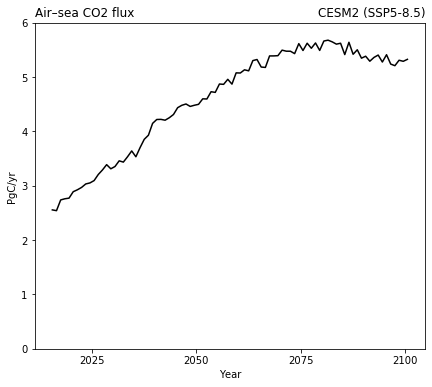

In [13]:
fig, ax = make_timeseries_plot('FG_CO2', 'cesm2_SSP5-8.5', exp_in_title='CESM2 (SSP5-8.5)', plot_all=False)
ax.set_ylim([0, 6])
plt.show()

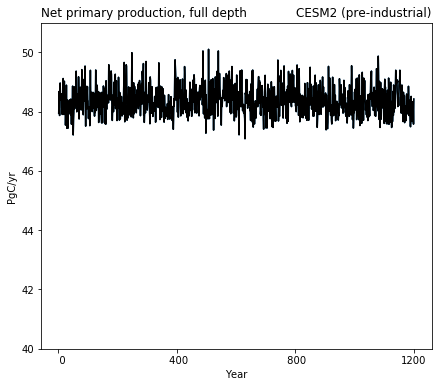

In [14]:
fig, ax = make_timeseries_plot('photoC_TOT_zint', 'cesm2_PI', exp_in_title='CESM2 (pre-industrial)')
ax.set_ylim([40, 51])
plt.show()

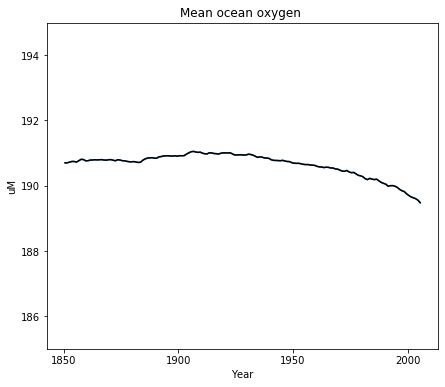

In [15]:
fig, ax = make_timeseries_plot('O2', 'cesm1_hist')
ax.set_ylim([185, 195])
plt.show()

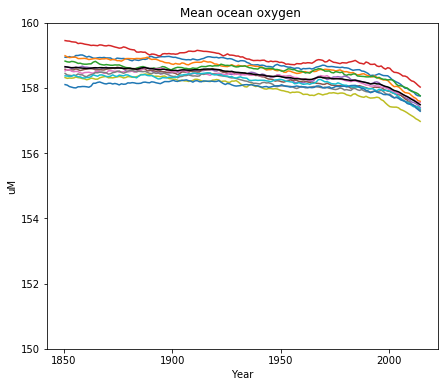

In [16]:
fig, ax = make_timeseries_plot('O2', 'cesm2_hist')
ax.set_ylim([150, 160])
plt.show()

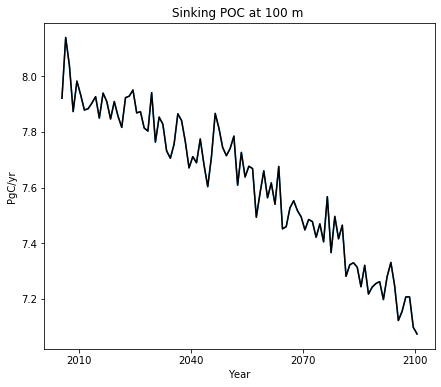

In [17]:
fig, ax = make_timeseries_plot('POC_FLUX_100m', 'cesm1_RCP85')
plt.show()

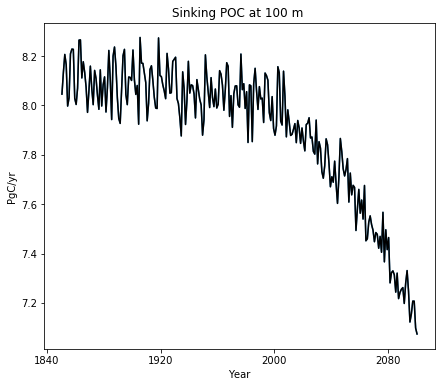

In [18]:
fig, ax = make_timeseries_plot('POC_FLUX_100m', 'cesm1_hist_RCP85')
plt.show()